In [1]:
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre

import matplotlib.pyplot as plt
import seaborn as sns


import garpar as gp 
import pandas as pd 
import numpy as np


In [84]:
wfci = pd.read_csv("/home/nadia/backupDrop/tesis doctoral 2/datosFCI_sin_cedears.csv")
wfci.columns = wfci.columns.str.strip()
wfci["Fondo"] = [
    "Galicia", 
    "BNA",
    "MACRO",
    "Credicoop",
    "ICBC",
    "Comafi",
    "HSBC",
    "Patagonia",
    "Mariva",
    "Supervielle",
    "Santander",
    "Bs.As.",
    "Val.Allaria",
    "Val.Arpenta",
    "Val.Bull",
    "Val.SBS",
    "Val.Valiant"]
    

In [85]:
wfci.Fondo

0         Galicia
1             BNA
2           MACRO
3       Credicoop
4            ICBC
5          Comafi
6            HSBC
7       Patagonia
8          Mariva
9     Supervielle
10      Santander
11         Bs.As.
12    Val.Allaria
13    Val.Arpenta
14       Val.Bull
15        Val.SBS
16    Val.Valiant
Name: Fondo, dtype: object

se toma un año de la cartera al considerar el horizonte temporar de la inersión. 
Se recomienda tomar un año en optimización de carteras para estimar los retornos.

In [86]:
mervalf = gp.datasets.load_MERVAL(first="29-07-2021", 
                                  last = "29-07-2022")
mervalf

Stocks,ALUA[⚖ 0.019231],BBAR[⚖ 0.019231],BYMA[⚖ 0.019231],CEPU[⚖ 0.019231],COME[⚖ 0.019231],CRES[⚖ 0.019231],CVH[⚖ 0.019231],EDN[⚖ 0.019231],GGAL[⚖ 0.019231],HARG[⚖ 0.019231],...,MOLA[⚖ 0.019231],MOLI[⚖ 0.019231],MORI[⚖ 0.019231],OEST[⚖ 0.019231],PATA[⚖ 0.019231],POLL[⚖ 0.019231],RIGO[⚖ 0.019231],SAMI[⚖ 0.019231],SEMI[⚖ 0.019231],TGLT[⚖ 0.019231]
Days,,,,,,,,,,,,,,,,,,,,,
2021-07-29,60.40,193.25,780.00,45.00,4.40,115.50,345.0,39.85,147.60,178.00,...,934.0,87.30,15.55,39.5,32.4,13.0,149.5,118.75,5.50,3.87
2021-07-30,60.30,188.80,780.00,44.65,4.33,112.25,339.0,39.00,142.55,176.00,...,894.0,85.40,15.45,39.5,32.2,15.0,149.0,117.75,5.45,3.80
2021-08-02,61.50,186.25,785.00,45.85,4.50,114.55,333.5,40.30,142.35,179.50,...,877.0,85.60,15.05,39.3,32.0,14.9,147.0,119.75,5.55,3.90
2021-08-03,61.10,185.00,790.00,44.65,4.50,111.70,332.0,41.00,145.60,179.25,...,957.0,88.00,15.20,39.0,32.0,14.9,147.0,120.00,5.55,3.80
2021-08-04,59.80,183.65,790.00,42.55,4.60,110.35,329.5,39.85,143.55,180.50,...,1030.0,88.70,15.00,36.5,32.1,14.8,147.0,122.00,5.40,3.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,144.75,251.85,204.50,104.10,15.75,164.90,686.0,75.60,214.35,194.50,...,2447.0,156.00,16.75,60.0,57.8,28.5,250.0,141.25,9.00,4.46
2022-07-26,139.50,257.75,205.50,106.30,15.30,174.90,700.5,75.90,214.50,201.00,...,2412.0,155.00,16.80,62.0,57.0,29.0,250.0,137.50,8.94,4.45
2022-07-27,146.50,274.85,222.00,117.55,16.25,183.50,707.5,79.00,225.65,210.00,...,2399.5,158.50,17.55,65.0,59.5,30.0,260.0,142.00,9.28,4.53


In [109]:
def asignw(nfondo):
    fondo = wfci[wfci["Fondo"]== nfondo]
    weights = []
    for stock in mervalf.stocks:
        try:
            w = float(fondo[stock].values[0].replace(",","."))
        except KeyError:
            w = 0.
        weights.append(w)

    nm = mervalf.copy(weights=weights,title=nfondo).scale_weights()
    return nm

def get_metrics(nfondo):
    mopt = asignw(nfondo).dprune().wprune().scale_weights()
    metrics = {
        "Fondo": nfondo,
       # "entropy": entropy,
        "stocks_seleccionados": len(mopt.stocks),
        "beta_portafolio": mopt.risk.pf_beta(),
        "varianza_portafolio": mopt.risk.pf_var(),
        "VaR_portafolio": np.sum(mopt.risk.value() * mopt.weights),
        "Sharpe_Ratio": mopt.risk.sharpe(),
        "Treynor_Ratio": mopt.risk.treynor_ratio(),
        "Entropia_cruzada": mopt.div.cross_entropy(),
        "Entropia_KeyZang": mopt.div.ke_zang_entropy(),
        "Entropia_Zheng": mopt.div.zheng_entropy(),
        #"Delta_diversific": mopt.div.delta(),
        "Ratio_diversific": mopt.div.ratio(),
        "CV_Contribuciones_marginales":(mopt.div.mrc() *  mopt.weights).std() / (mopt.div.mrc() *  mopt.weights).mean(),
        "Indice_diversific_port": mopt.div.pdi(n_components=5, random_state=100),
    }
    return metrics
    

## Calculo de metricas

aca hago zaraza del zaraza

$u_9 = 23$

In [102]:
rows = []
for nfondo in wfci.Fondo:
    metrics = get_metrics(nfondo)
    rows.append(metrics)
metrics = pd.DataFrame(rows)
metrics.set_index("Fondo", inplace=True, drop=True)
metrics

,stocks_seleccionados,beta_portafolio,varianza_portafolio,VaR_portafolio,Sharpe_Ratio,Treynor_Ratio,Entropia_cruzada,Entropia_KeyZang,Entropia_Zheng,Ratio_diversific $\mu$,CV_Contribuciones_marginales,Indice_diversific_port
Fondo,,,,,,,,,,,,
Galicia,27,1.673191,0.106095,0.040332,-3.237707,-0.642242,1.026304,2.754291,2.648196,0.094987,1.352807,1.356961
BNA,19,1.305662,0.107886,0.040073,-2.825605,-0.726144,0.514198,2.696622,2.588735,0.093679,0.963059,1.708972
MACRO,19,1.704964,0.112052,0.040180,-2.813989,-0.564210,0.778968,2.470591,2.358540,0.092209,1.225660,1.689137
Credicoop,18,1.354701,0.102477,0.039187,-2.891776,-0.698101,0.454785,2.710788,2.608311,0.096451,0.810086,1.673447
ICBC,26,1.468175,0.088988,0.038297,-3.360620,-0.696445,0.678679,2.903753,2.814764,0.102112,1.055144,1.381591
Comafi,7,0.976238,0.119388,0.040135,-2.818415,-1.018025,0.192727,1.906383,1.786995,0.081438,0.506193,3.650204
HSBC,24,1.876506,0.104736,0.039604,-3.210461,-0.564347,1.009999,2.677716,2.572979,0.096354,1.240999,1.369945
Patagonia,16,0.920309,0.115454,0.040872,-2.812602,-1.060166,0.386546,2.556743,2.441289,0.089836,0.925144,1.914891
Mariva,15,1.463561,0.111366,0.040206,-2.223565,-0.520673,0.729467,2.316669,2.205304,0.096718,1.041671,1.936375


In [103]:
objectives = [
    max, #     'stocks_seleccionados', coincide con definición mayor número de stocks
    min, #     'beta_portafolio', ver estaría bueno fuera cercana a 1 a màs o menos pronbunciada que el mercado. Ver RIM 
    min, #     'varianza_portafolio',
    max, #     'VaR_portafolio', es el valor promedio ponderado que asigna una probabilidad del 5% a tener pérdida, se busca lo más alto posible para que pequeños movimientos no afecten  
    max, #     'Sharpe_Ratio', es el exceso de rendimiento sobre la tasa libre de riesgo en relación a la variabilidad, busco maximizar porque denominador debe hacerse más pequeño y numerador más grande 
    max, #     'Treynor_Ratio', mide el rendimiento en relación al Beta_i
    min, #     'Entropia_cruzada', mide el desorden al compararlo con una estrategia teórica de riski part equall
    min, #     'Entropia_KeyZang', considera una medida de eentropía y variabilidad
    min, #     'Entropia_Zheng', 
    max, #     'Ratio_diversific', mide la diversificación ganada por  mantener activos no correlacionados
    min, #     'CV_Contribuciones_marginales', si todos los activos tienen igual contribución marginal es un portfolio diversificado
    max, #     'Indice_diversific_port, si hay correlacióan alta el índice dará un valor bajo mientras que si no hay correlación el índice tenderá al valor N
]

dm = skc.mkdm(metrics.to_numpy(), objectives, alternatives=metrics.index, criteria=metrics.columns)

In [110]:
pipe = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.Critic(),
    similarity.TOPSIS(),
)
pipe

SKCPipeline(steps=[('negateminimize', NegateMinimize()), ('sumscaler', SumScaler(target='matrix')), ('critic', Critic(correlation=<function pearson_correlation at 0x7f05ed743ca0>, scale=True)), ('topsis', TOPSIS(metric='euclidean'))])

In [111]:
result = pipe.evaluate(dm)
result

,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,11,5,13,6,7,4,10,8,2,1,12,17,14,9,15,16


In [112]:
result.e_.similarity

array([0.55205637, 0.3835364 , 0.46874065, 0.34773412, 0.46136856,
       0.41868557, 0.53281144, 0.39146407, 0.41228412, 0.5649925 ,
       0.59934309, 0.35901587, 0.27918637, 0.33833622, 0.41158385,
       0.30929568, 0.30898684])

In [113]:
dmt = pipe.transform(dm)


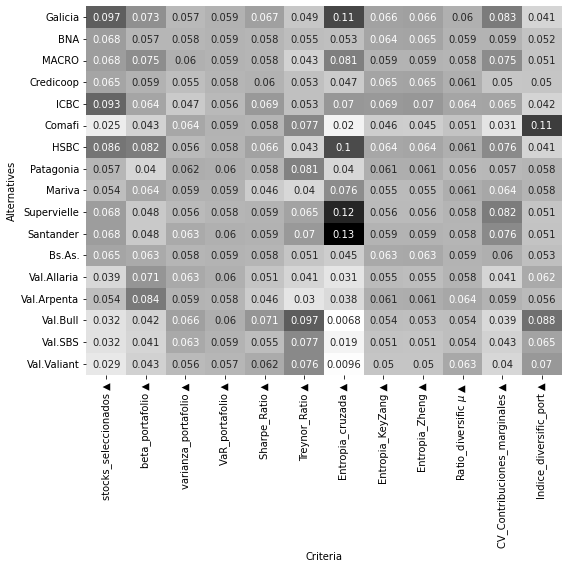

In [114]:
fig, ax = plt.subplots(figsize=(8,8))
dmt.plot(ax=ax, cbar=False, cmap="Greys")
fig.tight_layout()

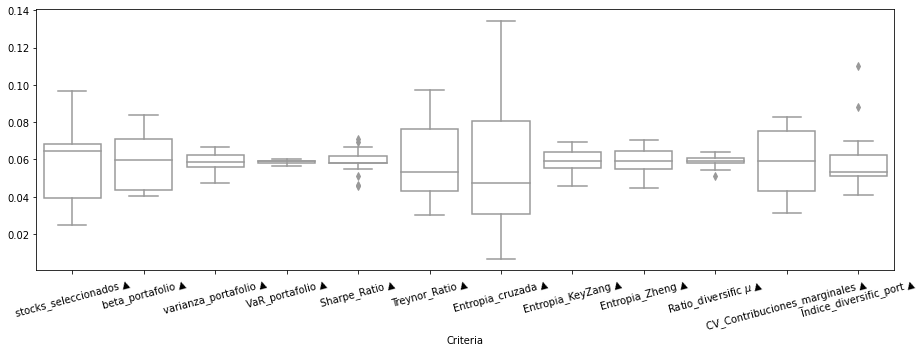

In [115]:
fig, ax = plt.subplots(figsize=(13,5))
dmt.plot.box(ax=ax, color="w")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
fig.tight_layout()

<AxesSubplot:>

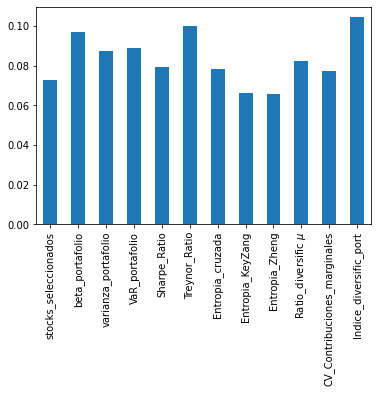

In [116]:
dmt.weights.plot.bar()

<AxesSubplot:ylabel='Frequency'>

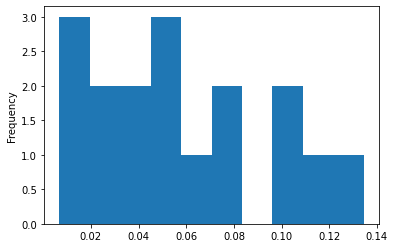

In [117]:
dmt.criteria["Entropia_cruzada"].plot.hist()

<AxesSubplot:ylabel='Proportion'>

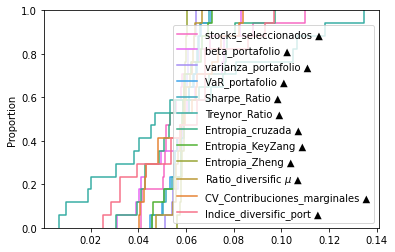

In [119]:
dmt.plot.ogive()

<AxesSubplot:ylabel='Density'>

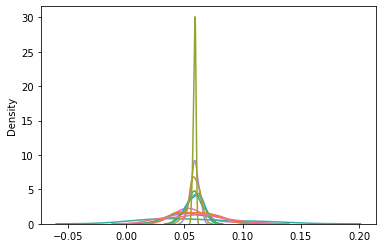

In [122]:
dmt.plot.kde(legend=False)